<a href="https://colab.research.google.com/github/simulate111/Introduction-to-Artificial-Intelligence/blob/main/notebooks/Stable-diffusion-XL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text to images with Stable Diffusion XL

This notebook has been written for demonstration purposes by [Arno Solin](https://arno.solin.fi) and [Marcus Klasson](https://marcusklasson.github.io) in university teaching. Use for anything outside the given examples is solely at your own risk. Authors are not responsible for any outcomes or uses of the AI-generated content.

*The model used in this demo is licensed with a [CreativeML OpenRAIL++ license](https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL). The authors of the model claim no rights on the outputs you generate, you are free to use them and are accountable for their use which must not go against the provisions set in this license. The license forbids you from sharing any content that violates any laws, produce any harm to a person, disseminate any personal information that would be meant for harm, spread misinformation and target vulnerable groups. For the full list of restrictions please read the license.*

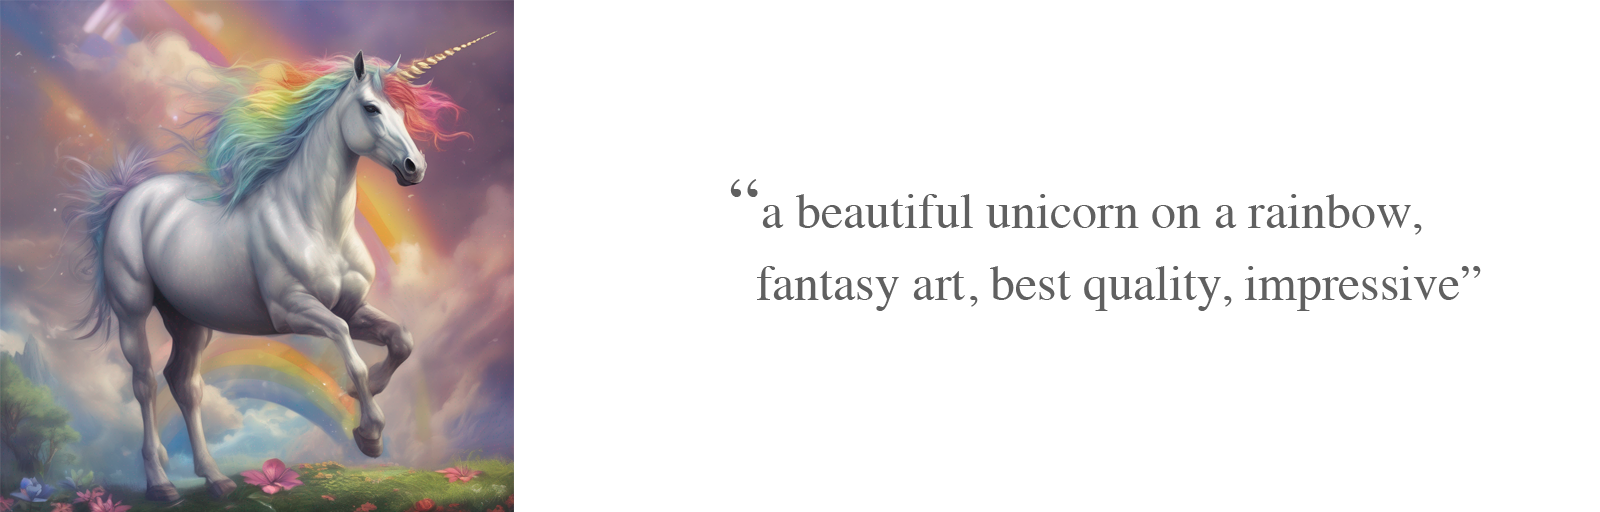

## Introduction

Stable Diffusion stems from a class of deep generative models called diffusion models which can generate images from random numbers (noise). To guide the image generation procedure, we can condition the model on some class label, e.g., 'cat', or a text description to generate images that should include things what we request. Stable Diffusion gets guidance from text prompts where it is up to the user to come up with clever prompts to obtain images with the correct content and desired style.    

In this exercise, we will generate images from written text prompts with a pre-trained Stable Diffusion XL model. We have implmented the following tasks for you to play around with:
1. Generate your (potentially) first image with Stable Diffusion
2. Generate images using different number of inference steps
3. Generate images with varying prompts
4. Generate images with negative prompts
5. Generate image with a text prompt and an initial image using the image-to-image version of Stable Diffusion

We have provided some example text prompts for each task. **Feel free to write your own text prompts to generate images.**

**Be aware of that the image generation typically takes up to 30 seconds even though you use a GPU**

## Getting started

You first need to set up the environment and install some additional Python packages into it. Run the cells below by clcking on the play symbol on left side of the cell or by activating the cell and pressing SHIFT+ENTER on your keyboard.

First, please make sure you are using a GPU runtime to run this notebook, so inference is much faster. If the following command fails, use the `Runtime` menu above and select `Change runtime type`.

In [ ]:
%pip install --quiet --upgrade diffusers transformers accelerate invisible_watermark mediapy

## Loading the Stable Diffusion model

The trained Stable Diffusion model is hosted on [Hugging Face](https://huggingface.co/spaces/stabilityai/stable-diffusion). Running the cell below will set up things and download the trained model `stabilityai/stable-diffusion-xl-base-1.0`. **This should take some minutes.**

The Stable Diffusion model will be defined in the object named `pipe` after running the cell.

In [ ]:
import mediapy as media
import random
import sys
import torch

from diffusers import DiffusionPipeline

# Use the additional refiner to further improve quality?
use_refiner = False

# Set up the pipe from the desiered model
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
    )

if use_refiner:
  refiner = DiffusionPipeline.from_pretrained(
      "stabilityai/stable-diffusion-xl-refiner-1.0",
      text_encoder_2=pipe.text_encoder_2,
      vae=pipe.vae,
      torch_dtype=torch.float16,
      use_safetensors=True,
      variant="fp16",
  )
  refiner = refiner.to("cuda")
  pipe.enable_model_cpu_offload()
else:
  pipe = pipe.to("cuda")

## Set the random seed

The `seed` below specifies how to initialize the random number generator in the model. In addition to the text, Stable Diffusion is initialized with a fixed amount of "random" numbers, where the seed determines how these numbers should be drawn randomly. Setting the seed is a helpful tool when debugging machine learning models and algorithms.

Run the cell below to set the seed. **Feel free to set the seed to any non-negative number you wish.**

**Note: You will generate different images for different seeds.**

In [ ]:
seed = 42

# or set to a random number
# seed = random.randint(0, sys.maxsize)

## Task 1: Generate an image with Stable Diffusion from text input

Now you can generate images by inputting text of your choice to the Stable Diffusion model.

The `prompt` below specifies the input and running the cell will pass it to the model and finally display the generated content.

**Note** that the time to generate an image varies depending on the hardware that you have access to.

Generating this image should take **less than one minute** on a GPU.

In [ ]:
prompt = "a happy student working on their laptop, professional photography, 35mm, best quality"

images = pipe(
    prompt = prompt,
    generator = torch.Generator("cuda").manual_seed(seed),
    ).images

print(f"Prompt:\t{prompt}\nSeed:\t{seed}")
media.show_images(images)

# Optionally save the output as a file
#images[0].save("output.jpg")

## Task 2: Images from different inference steps
We can inspect what the generated images look like at different number of inference steps. An inference step involves a forward pass of the the text prompt and the current image passed as input to Stable Diffusion. The first inference step involves inputting an image with random pixels together with the written text prompt to obtain the generated image. The subsequent inference steps then uses the last generated image as input together with the text prompt to refine the generated image.

Given a text prompt, we will generate images at different inference steps and inspect the resulting output images by running the cell below.

**Be patient. Generating these images will probably take a few minutes.**

In [ ]:
prompt = "a beautiful unicorn on a rainbow, fantasy art, best quality, impressive"

# What happens when you run the model 1,2,5,10, or 50 steps?
num_inference_steps = 3

images = pipe(
    prompt = prompt,
    num_inference_steps = num_inference_steps,
    generator = torch.Generator("cuda").manual_seed(seed),
    ).images

print(f"Prompt:\t{prompt}\nSeed:\t{seed}")
media.show_images(images)

## Task 3: Changing the text prompt

We can add more descriptions for the image in the text prompt to further instruct Stable Diffusion on what type of generated image we want.

In this task, we begin with a base text prompt and then extend the text prompt with different additional text prompts. We have provided four different additional prompts to try out.

You may also separate words with commas like `"high quality, cartoon"`, which may help the model to recognize the given text prompt better.

In [ ]:
prompt = "a beautiful unicorn on a rainbow, cartoon, best quality, impressive"

images = pipe(
    prompt = prompt,
    generator = torch.Generator("cuda").manual_seed(seed),
    ).images

print(f"Prompt:\t{prompt}\nSeed:\t{seed}")
media.show_images(images)

## Task 4: Add a negative prompt as input

Stable Diffusion can use negative prompts to instruct the model of what it should *not* include in the generated images.

In this task, we provide a text prompt to the model to instruct what type of images we want as well as a negative prompt where we tell the model what we want it to avoid generating. We have provided four different negative prompts to try out.

Feel free to change the `prompt` and `negative_prompt`. Place the negative prompt within quotation marks "...". Adding several words separated by commas (e.g., "bad quality, cartoon") may help the model to recognize the given negative text prompt better.

In [ ]:
prompt = "a happy student working on their laptop, professional photography, 35mm, best quality"
negative_prompt = "curly hair"

# ... or things such as ...
# blender, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, blurry, bad art, blurred, text, watermark, disfigured, deformed, closed eyes

images = pipe(
    prompt = prompt,
    negative_prompt = negative_prompt,
    generator = torch.Generator("cuda").manual_seed(seed),
    ).images

print(f"Prompt:\t{prompt}\nSeed:\t{seed}")
media.show_images(images)

## Task 5: Image-to-image Generation

Stable Diffusion can generate images from a rough image sketches and text prompts. This is called image-to-image generation, where Stable Diffusion will refine an image template by filling it in with the infomration from the text prompt.  

In this example, our initial image will be a rough sketch made by the course personnel of the Aalto University logo on a green landscape with a river.

### Release memory

Since the Stable Diffusion model is quite large (5GB), the notebook could crash if you load another model without releasing the memory of the first model due to the low memory limit we may have have access to.

Run the following command that deletes the first model in `pipe` to release its memory before loading the image-to-image generation model.

In [ ]:
# Release memory of previous model before loading image-to-image model
del pipe

### Load model

In [ ]:
import torch
from diffusers import StableDiffusionXLImg2ImgPipeline
from diffusers.utils import load_image

pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipe = pipe.to("cuda")

### Load initial image sketch

Run the cell below to load and display the image that we will refine using a text prompt and Stable Diffusion.

In [ ]:
url = "https://raw.githubusercontent.com/asolin/notebooks/main/notebooks/images/img2img-aalto-input.png"
init_image = load_image(url).convert("RGB")
init_image

Run the cell below to set the `prompt` and `negative_prompt` of what the refined image should look like.

**Feel free to change the prompts.**


In [ ]:
prompt = "A fantasy landscape with a giant sculpture of the capital letter A and an exclamation mark in the middle, fresh, fantasy photograph, realistic, best quality"
images = pipe(prompt, image=init_image,strength=0.7,guidance_scale=4.5,num_inference_steps=15).images
media.show_images(images)


## Optional: Use the 'refiner' to further improve the quality

If you modify the loading of the model at the very top of this document to also load the optional refiner model, you should be able to see subtle improvements in the image quality. Try this by setting `use_refiner=True` at the top of the document. You may also need to release memory as you did for the image-to-image generation earlier.

After making those changes, you can run both the generation and refiner using the example code below.

In [ ]:
prompt = "a happy student working on their laptop, professional photography, 35mm, best quality"

images = pipe(
    prompt = prompt,
    output_type = "latent" if use_refiner else "pil",
    generator = torch.Generator("cuda").manual_seed(seed),
    ).images

if use_refiner:
  images = refiner(
      prompt = prompt,
      image = images,
      ).images

print(f"Prompt:\t{prompt}\nSeed:\t{seed}")
media.show_images(images)

# Optionally save the output as a file
#images[0].save("output.jpg")